In [2]:
from lxmert.lxmert.src.modeling_frcnn import GeneralizedRCNN
import lxmert.lxmert.src.vqa_utils as utils
from lxmert.lxmert.src.processing_image import Preprocess
from transformers import LxmertTokenizer
from lxmert.lxmert.src.huggingface_lxmert import LxmertForQuestionAnswering
from lxmert.lxmert.src.lxmert_lrp import LxmertForQuestionAnswering as LxmertForQuestionAnsweringLRP
from tqdm import tqdm
from lxmert.lxmert.src.ExplanationGenerator import GeneratorOurs, GeneratorBaselines, GeneratorOursAblationNoAggregation
import random
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.transforms as transforms
from captum.attr import visualization
import requests

In [3]:
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
VQA_URL = "https://raw.githubusercontent.com/airsplay/lxmert/master/data/vqa/trainval_label2ans.json"

In [4]:
class ModelUsage:
    def __init__(self, use_lrp=False):
        self.vqa_answers = utils.get_data(VQA_URL)

        # load models and model components
        self.frcnn_cfg = utils.Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
        self.frcnn_cfg.MODEL.DEVICE = "cuda"

        self.frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=self.frcnn_cfg)

        self.image_preprocess = Preprocess(self.frcnn_cfg)

        self.lxmert_tokenizer = LxmertTokenizer.from_pretrained("unc-nlp/lxmert-base-uncased")

        if use_lrp:
            self.lxmert_vqa = LxmertForQuestionAnsweringLRP.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")
        else:
            self.lxmert_vqa = LxmertForQuestionAnswering.from_pretrained("unc-nlp/lxmert-vqa-uncased").to("cuda")

        self.lxmert_vqa.eval()
        self.model = self.lxmert_vqa

        # self.vqa_dataset = vqa_data.VQADataset(splits="valid")

    def forward(self, item):
        URL, question = item
        
        self.image_file_path = URL

        # run frcnn
        images, sizes, scales_yx = self.image_preprocess(URL)
        output_dict = self.frcnn(
            images,
            sizes,
            scales_yx=scales_yx,
            padding="max_detections",
            max_detections= self.frcnn_cfg.max_detections,
            return_tensors="pt"
        )
        inputs = self.lxmert_tokenizer(
            question,
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )
        self.question_tokens = self.lxmert_tokenizer.convert_ids_to_tokens(inputs.input_ids.flatten())
        self.text_len = len(self.question_tokens)
        # Very important that the boxes are normalized
        normalized_boxes = output_dict.get("normalized_boxes")
        features = output_dict.get("roi_features")
        self.image_boxes_len = features.shape[1]
        self.bboxes = output_dict.get("boxes")
        self.output = self.lxmert_vqa(
            input_ids=inputs.input_ids.to("cuda"),
            attention_mask=inputs.attention_mask.to("cuda"),
            visual_feats=features.to("cuda"),
            visual_pos=normalized_boxes.to("cuda"),
            token_type_ids=inputs.token_type_ids.to("cuda"),
            return_dict=True,
            output_attentions=False,
        )
        return self.output

In [30]:
def save_image_vis(image_file_path, bbox_scores):
#     bbox_scores = image_scores
    _, top_bboxes_indices = bbox_scores.topk(k=1, dim=-1)
    img = cv2.imread(image_file_path)
    mask = torch.zeros(img.shape[0], img.shape[1])
    for index in range(len(bbox_scores)):
        [x, y, w, h] = model_lrp.bboxes[0][index] # zero is batch_index
        curr_score_tensor = mask[int(y):int(h), int(x):int(w)]
        new_score_tensor = torch.ones_like(curr_score_tensor)*bbox_scores[index].item()
        mask[int(y):int(h), int(x):int(w)] = torch.max(new_score_tensor,mask[int(y):int(h), int(x):int(w)])
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    mask = mask.unsqueeze_(-1)
    mask = mask.expand(img.shape)
    img = img * mask.cpu().data.numpy()
    cv2.imwrite(
            'lxmert/lxmert/experiments/paper/new.jpg', img)

In [31]:
model_lrp = ModelUsage(use_lrp=True)
lrp = GeneratorOurs(model_lrp)
baselines = GeneratorBaselines(model_lrp)
vqa_answers = utils.get_data(VQA_URL)

# baselines.generate_transformer_attr(None)
# baselines.generate_attn_gradcam(None)
# baselines.generate_partial_lrp(None)
# baselines.generate_raw_attn(None)
# baselines.generate_rollout(None)

image_ids = [
    # giraffe
    'COCO_val2014_000000185590',
    # baseball
    'COCO_val2014_000000127510',
    # bath
    'COCO_val2014_000000324266',
    # frisbee
    'COCO_val2014_000000200717'
]

test_questions_for_images = [
    ################## paper samples
    # giraffe
    "is the animal eating?",
    # baseball
    "did he catch the ball?",
    # bath
    "is the tub white ?",
    # frisbee
    "did the man just catch the frisbee?"
    ################## paper samples
]

loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.


## Examples from paper

tensor([0.0282, 0.0150, 0.0175, 0.0110, 0.0122, 0.0778, 0.0097, 0.0078, 0.0072,
        0.0082, 0.0077, 0.0085, 0.0092, 0.0075, 0.0053, 0.0094, 0.0072, 0.0079,
        0.0066, 0.0101, 0.0080, 0.0055, 0.0052, 0.0481, 0.0084, 0.0087, 0.0074,
        0.0096, 0.0072, 0.0083, 0.0045, 0.0043, 0.0086, 0.0052, 0.0084, 0.0233],
       device='cuda:0')
torch.Size([1, 36, 4])


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,[CLS] is the animal eating ? [SEP]


ANSWER: no


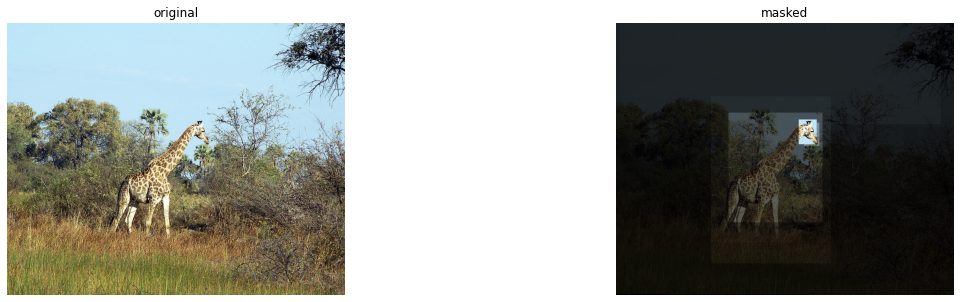

In [32]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[0])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[0]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,[CLS] did he catch the ball ? [SEP]


ANSWER: yes


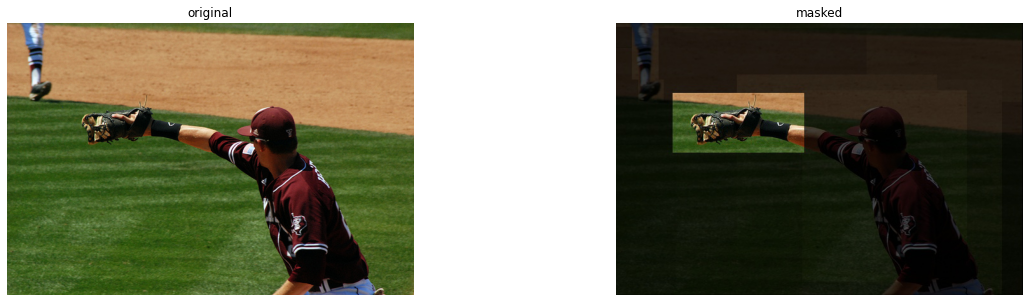

In [8]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[1])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[1]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,[CLS] is the tub white ? [SEP]


ANSWER: yes


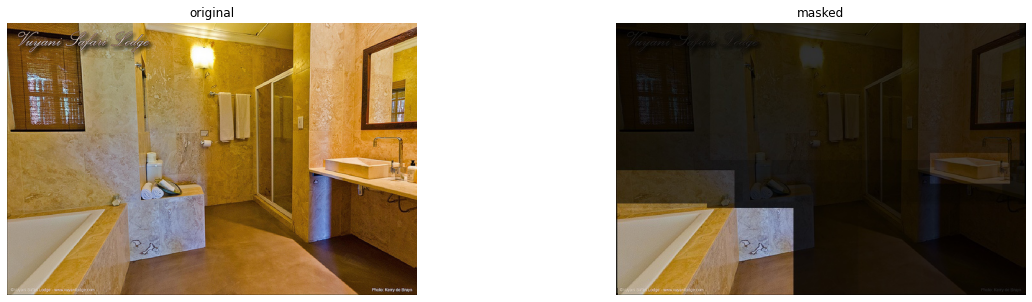

In [9]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[2])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[2]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
0,0 (0.00),0,0.00,[CLS] did the man just catch the fr ##is ##bee ? [SEP]


ANSWER: no


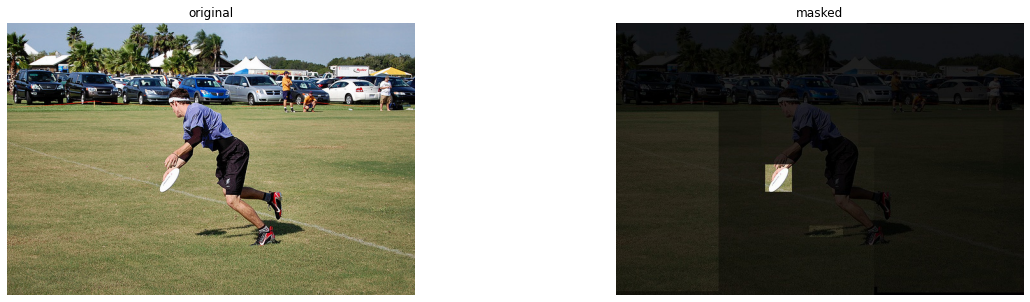

In [10]:
URL = 'lxmert/lxmert/experiments/paper/{0}/{0}.jpg'.format(image_ids[3])
R_t_t, R_t_i = lrp.generate_ours((URL, test_questions_for_images[3]), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

## Examples from online pictures

In [11]:
URL = "https://vqa.cloudcv.org/media/val2014/COCO_val2014_000000549112.jpg"

question =  'where is the knife?'

# save image to experiments folder
im = Image.open(requests.get(URL, stream=True).raw)
im.save('lxmert/lxmert/experiments/paper/online_image.jpg', 'JPEG')
URL = 'lxmert/lxmert/experiments/paper/online_image.jpg'

R_t_t, R_t_i = lrp.generate_ours((URL, question), use_lrp=False, normalize_self_attention=True, method_name="ours")
image_scores = R_t_i[0]
text_scores = R_t_t[0]
save_image_vis(URL, image_scores)
orig_image = Image.open(model_lrp.image_file_path)

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20, 5))
axs[0].imshow(orig_image);
axs[0].axis('off');
axs[0].set_title('original');

masked_image = Image.open('lxmert/lxmert/experiments/paper/new.jpg')
axs[1].imshow(masked_image);
axs[1].axis('off');
axs[1].set_title('masked');

text_scores = (text_scores - text_scores.min()) / (text_scores.max() - text_scores.min())
vis_data_records = [visualization.VisualizationDataRecord(text_scores,0,0,0,0,0,model_lrp.question_tokens,1)]
visualization.visualize_text(vis_data_records)
print("ANSWER:", vqa_answers[model_lrp.output.question_answering_score.argmax()])

SSLError: HTTPSConnectionPool(host='vqa.cloudcv.org', port=443): Max retries exceeded with url: /media/val2014/COCO_val2014_000000549112.jpg (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1091)')))